In [1]:
import sys

#https://pypi.org/project/python-mnist/
new_path = 'python-mnist/mnist'
sys.path.append(new_path)

#https://pypi.org/project/python-mnist/
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist

#https://pypi.org/project/python-mnist/
mndata = MNIST('./python-mnist/data')

images, labels = mndata.load_training()
n = len(images[0])
%matplotlib inline
import matplotlib.pyplot as plt

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)
m = int(np.sqrt(n))
C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C = C / np.median(C)
C[C==0] = 1e-4
#(C / np.median(C)).max()

In [2]:
delta = 1e-6
l = len(images)

In [3]:
def random_mnist():
    p, q = np.random.randint(l), np.random.randint(l)
    p, q = np.float64(images[p]), np.float64(images[q])
    p[p == 0] = delta
    q[q == 0] = delta
    return p / sum(p), q / sum(q)

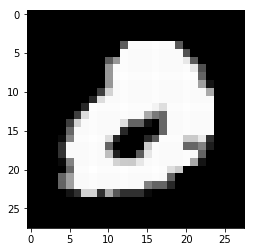

In [4]:
p, q = random_mnist()
plot = True
if plot:
    #plt.imshow(p.reshape(-1, m), cmap=plt.get_cmap('gray'))
    plt.imshow(q.reshape(-1, m), cmap=plt.get_cmap('gray'))

def mround(x):
    r = p / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p - F.dot(one)
    err_c = q - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [5]:
eps = 1e-2
gamma = eps/3/np.log(n)
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def f_(x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1)==0.] = 1.
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

def x_(la, mu):
    x_star = np.exp((-C - np.outer(la, one) - np.outer(one, mu)) / gamma - I)
    return x_star

def phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum()
                    
def grad_phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_grad_phi_(lamu):
    x_star = x_(lamu[:n], lamu[n:])
    return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum(), np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)

def phi_1d_(x, e):
    def f1d(h):
        return phi_(x + h * e)
    return f1d

def grad_phi_1d_(x, e):
    def gradf1d(h):
        return np.array(grad_phi_(x + h * e).dot(e))
    return gradf1d

def phi_grad_phi_1d_(x, e):
    def fgradf1d(h):
        lamu = x + h * e
        x_star = x_(lamu[:n], lamu[n:])
        return lamu[:n].dot(p) + lamu[n:].dot(q) + gamma * x_star.sum(), np.array(np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0).dot(e))
    return fgradf1d    

def universal(f_, grad_f_, f_grad_f_, x, eps):
    L = 1.
    betta = alpha = 0.
    n = x.shape[0]
    while True:
        L = L / 2
        while True:
            f_x, grad_f_x = f_grad_f_(x)
            x_new = x - grad_f_x / L
            dx = x_new - x
            f_x_new = f_(x_new)
            if f_x_new <= f_x + grad_f_x.dot(dx) + L * dx.dot(dx) / 2:
                break    
            else:
                L = L * 2
        if abs(f_x - f_x_new) < eps:
            return x_new, f_x_new
        if np.linalg.norm(x - x_new) < eps:
            return x_new, f_x_new
        x = x_new.copy()

def binary(f, a, b, epsilon):
    c = (a + b) / 2
    while abs(b - a) > epsilon:
        y = (a + c) / 2.0
        if f(y) <= f(c):
            b = c
            c = y
        else:
            z = (b + c) / 2.0
            if f(c) <= f(z):
                a = y
                b = z
            else:
                a = c
                c = z
    return c, f(c)

# 1802.04367

In [6]:
def APDAGD(N):
    L = 1.
    betta = alpha = 0.
    x_hat = np.zeros([n, n], np.float64)
    z = np.zeros(2*n, np.float64)
    z_new = np.zeros(2*n, np.float64)
    eta = np.zeros(2*n, np.float64)
    eta_new  = np.zeros(2*n, np.float64)
    k=0
    phi_etas = []
    phis = []
    xs = []
    while k < N:
        L = L / 2
        while True:
            alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
            betta_new = betta + alpha_new
            tau = alpha_new / betta_new
            lamu_new = tau * z + (1 - tau) * eta
            
            #phi_new, grad_phi_new = phi_grad_phi_(lamu_new)
            x_star = x_(lamu_new[:n], lamu_new[n:])
            phi_new = lamu_new[:n].dot(p) + lamu_new[n:].dot(q) + gamma * x_star.sum()
            grad_phi_new = np.concatenate((p - x_star.dot(one), q - (x_star.T).dot(one)), 0)
            
            z_new = z - alpha_new * grad_phi_new
            eta_new = tau * z_new + (1-tau) * eta
            phi_eta = phi_(eta_new)
            if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
                alpha, betta = alpha_new, betta_new
                z = z_new.copy()
                eta = eta_new.copy()
                break    
            L = L * 2
        x_hat = tau * x_star + (1 - tau) * x_hat
        xs.append(x_hat)
        phis.append(phi_new)    
        k=k+1
    return phis, xs

# 1809.05895

In [9]:
def AGMsDR(N):
    A = 0.
    x = 0.* np.ones(2*n, np.float64)
    v = x.copy()
    psi_A = 0.5
    psi_b = x.copy()
    k=0
    h = 0
    phis = []
    lamus = []
    while k < N:
        betta, f_y = binary(phi_1d_(v, x - v), 0., 1., 0.01)
        #betta, f_y =  universal(phi_1d_(v, x-v), grad_phi_1d_(v, x-v), phi_grad_phi_1d_(v, x-v), np.zeros(1, np.float64), 0.000001)
        if False:
            xx = np.linspace(betta - 0.01*betta, betta + 0.01*betta, 10)
            yy = [(phi_1d_(v, x-v))(j) for j in xx]
            plt.plot(xx, yy)
            plt.show()
        y = v + betta * (x - v)
        grad_f_y = grad_phi_(y)
        norm_grad_f_y = np.linalg.norm(grad_f_y)
        grad_f_sharp = grad_f_y / norm_grad_f_y
        h, f_x =  universal(phi_1d_(y, -grad_f_sharp), grad_phi_1d_(y, -grad_f_sharp), phi_grad_phi_1d_(y, -grad_f_sharp), 0.*np.ones(1, np.float64), 0.000001)
        if False:
            xx = np.linspace(h - 0.01*h, h + 0.01*h, 10)
            yy = [(phi_1d_(y, -grad_f_sharp))(j) for j in xx]
            plt.plot(xx, yy)
            plt.show()
        x = y - h * grad_f_sharp
        g, a = (f_x - f_y), norm_grad_f_y**2
        alpha = (-g + np.sqrt(g*g - 2*a*g*A)) / a 
        A = A + alpha
        psi_b = psi_b + alpha * (grad_f_y)
        v = psi_b / psi_A
        k = k + 1
        phis.append(f_x)
        lamus.append(x)
    return phis, lamus

# Comparison

In [10]:
p, q = random_mnist()

N = 28
phis1, xs1 = APDAGD(N)

phis2, lamus2 = AGMsDR(N)

# Dual Objective vs Iterations

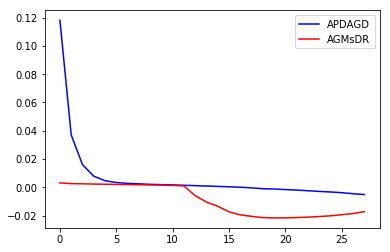

In [11]:
fig, ax = plt.subplots()
ax.plot(phis1, '-b', label='APDAGD')
ax.plot(phis2, '-r', label='AGMsDR')
leg = ax.legend();

# Reguralized Primal vs Iteration

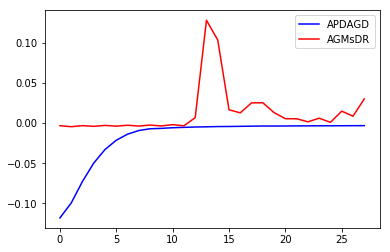

In [12]:
xs2 = [x_(i[:n], i[n:]) for i in lamus2]
f1 = [f_(i) for i in xs1]
f2 = [f_(i) for i in xs2]
fig, ax = plt.subplots()
ax.plot(f1, '-b', label='APDAGD')
ax.plot(f2, '-r', label='AGMsDR')
leg = ax.legend();

# Non-eguralized Primal vs Iteration

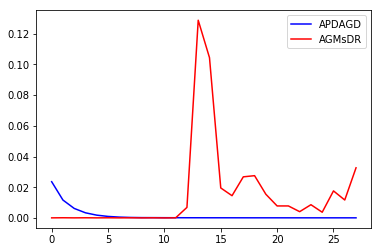

In [13]:
f1 = [f_true(i) for i in xs1]
f2 = [f_true(i) for i in xs2]
fig, ax = plt.subplots()
ax.plot(f1, '-b', label='APDAGD')
ax.plot(f2, '-r', label='AGMsDR')
leg = ax.legend();

# Non-reguralized Primal vs Iteration with Rounding

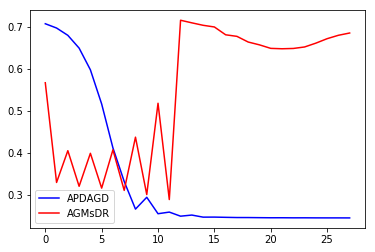

In [14]:
f1 = [f_true(mround(i)) for i in xs1]
f2 = [f_true(mround(i)) for i in xs2]
fig, ax = plt.subplots()
ax.plot(f1, '-b', label='APDAGD')
ax.plot(f2, '-r', label='AGMsDR')
leg = ax.legend();